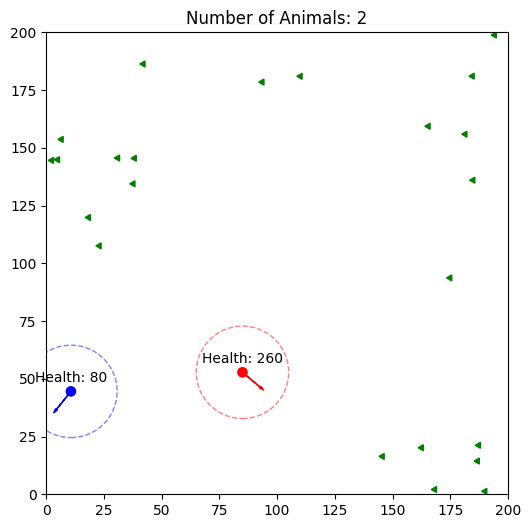

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from IPython.display import clear_output
import time

# Field dimensions
FIELD_SIZE = 200

# Initialize animals
animals = []

class Animal:
    def __init__(self, position, size=2, speed=1, health=100, radius_of_view=20, direction_change_interval=10, color='blue'):
        self.position = np.array(position, dtype='float')
        self.size = size
        self.speed = speed
        self.health = health
        self.radius_of_view = radius_of_view
        self.direction_change_interval = direction_change_interval
        self.steps_in_current_direction = 0
        self.current_direction = None  # Will be set when needed
        self.color = color

    def move(self, food_items):
        # Check for food within radius of view
        if food_items:
            food_positions = np.array([food.position for food in food_items])
            distances = np.linalg.norm(food_positions - self.position, axis=1)

            # Filter food within radius of view
            within_view = distances <= self.radius_of_view

            if np.any(within_view):
                # Get the closest food item
                closest_food_idx = np.argmin(distances[within_view])
                closest_food_position = food_positions[within_view][closest_food_idx]

                # Calculate direction vector towards the food
                direction = closest_food_position - self.position
                direction = direction / np.linalg.norm(direction)  # Normalize

                # Move towards the food
                self.position += direction * self.speed

                # Reset random movement counters
                self.steps_in_current_direction = 0
                self.current_direction = None
            else:
                # Random movement with fixed direction for a number of steps
                self.random_move()
        else:
            # No food left, move randomly
            self.random_move()

        # Keep within field bounds
        self.position = np.clip(self.position, 0, FIELD_SIZE)

        # Decrease health
        self.health -= 0.5  # Health decreases by 0.5 each move

    def random_move(self):
        if self.steps_in_current_direction == 0 or self.current_direction is None:
            # Choose a new random direction
            angle = np.random.uniform(0, 2 * np.pi)
            self.current_direction = np.array([np.cos(angle), np.sin(angle)])
            self.steps_in_current_direction = self.direction_change_interval

        # Move in the current direction
        self.position += self.current_direction * self.speed
        self.steps_in_current_direction -= 1

    def is_alive(self):
        return self.health > 0

class Food:
    def __init__(self, position):
        self.position = np.array(position)

def simulate(animals, food_items, steps=100):
    for step in range(steps):
        # Remove animals that have run out of health
        animals = [animal for animal in animals if animal.is_alive()]
        if not animals:
            print("All animals have run out of health.")
            break

        # Move each animal
        for animal in animals:
            animal.move(food_items)

        # Check for collisions with food for each animal
        remaining_food = food_items.copy()
        for animal in animals:
            for food in remaining_food[:]:
                distance = np.linalg.norm(animal.position - food.position)
                if distance < animal.size:
                    animal.health += 20  # Health replenished by 20
                    remaining_food.remove(food)
                    print(f"Animal at {animal.position} consumed food at {food.position}. Health is now {animal.health}.")
        food_items = remaining_food

        # Visualize the field
        visualize(animals, food_items)

        # Pause for visualization
        time.sleep(0.1)
        clear_output(wait=True)

def visualize(animals, food_items):
    fig, ax = plt.subplots(figsize=(6,6))

    # Draw the animals
    for animal in animals:
        circle = Circle(animal.position, animal.size, color=animal.color)
        ax.add_patch(circle)

        # Draw the radius of view
        view_circle = Circle(animal.position, animal.radius_of_view, color=animal.color, fill=False, linestyle='--', alpha=0.5)
        ax.add_patch(view_circle)

        # Draw the movement direction (if moving randomly)
        if animal.current_direction is not None and animal.steps_in_current_direction > 0:
            # Scale the arrow for visualization purposes
            arrow_scale = animal.size * 5
            ax.arrow(animal.position[0], animal.position[1],
                     animal.current_direction[0] * arrow_scale,
                     animal.current_direction[1] * arrow_scale,
                     head_width=1, head_length=2, fc=animal.color, ec=animal.color)

        # Display health value near the animal
        ax.text(animal.position[0], animal.position[1] + animal.size + 2, f"Health: {int(animal.health)}", 
                color='black', fontsize=10, ha='center')

    
    # Draw the food items
    for food in food_items:
        triangle = RegularPolygon(food.position, numVertices=3, radius=1.5, orientation=np.pi/2, color='green')
        ax.add_patch(triangle)

    # Set field limits
    ax.set_xlim(0, FIELD_SIZE)
    ax.set_ylim(0, FIELD_SIZE)

    # Maintain equal aspect ratio
    ax.set_aspect('equal', 'box')
    
    ax.set_title(f"Number of Animals: {len(animals)}")
    plt.show()

# Create two animals with different starting positions
animal1 = Animal(position=[FIELD_SIZE / 4, FIELD_SIZE / 4],
                 size=2, speed=2, health=100,
                 radius_of_view=20, direction_change_interval=10, color='blue')
animal2 = Animal(position=[3 * FIELD_SIZE / 4, 3 * FIELD_SIZE / 4],
                 size=2, speed=2, health=100,
                 radius_of_view=20, direction_change_interval=10, color='red')

animals.append(animal1)
animals.append(animal2)

# Generate random food positions
num_food_items = 40
food_items = []
for _ in range(num_food_items):
    pos = np.random.uniform(0, FIELD_SIZE, size=2)
    food_items.append(Food(position=pos))

# Run the simulation
simulate(animals, food_items, steps=200)